# Imminent ICU Admission and Prolonged Stay Prediction

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import pdb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=5)

import pandas as pd
import pickle

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *

from skorch import NeuralNetBinaryClassifier, NeuralNetClassifier, NeuralNet
from skorch.dataset import CVSplit
from skorch.callbacks import *

from classifier_model import NNClassifier
from utils.embeddings import PretrainedEmbeddings
from utils.splits import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/dl'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime',
  'chartinterval'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'device': 'cuda:2',
 'start_seed': 127,
 'min_freq': 3,
 'batch_size': 128,
 'hidden_dim': 100,
 'dropout_p': 0.1,
 'lr': 0.001,
 'wd': 0.001,
 'max_lr': 0.1,
 'max_epochs': 100,
 'ia_thresh': 0.2,
 'ps_thresh': 0.5}

## Dev

### Imminent ICU Admission

In [3]:
seed = 643
full_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ori_df = full_df.loc[(full_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ori_df = set_group_splits(ori_df.copy(), group_col='hadm_id', seed=seed)

In [4]:
df = ori_df
# df = ori_df.sample(1000).reset_index(drop=True)
df.groupby(['split', 'imminent_adm_label']).size()

split  imminent_adm_label
test   0                     6309 
       1                     1817 
train  0                     32494
       1                     10189
dtype: int64

In [5]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, binary=True, analyzer=str.split, sublinear_tf=True)

x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note']).astype(np.float32)
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note']).astype(np.float32)

x_train = np.asarray(x_train.todense())
x_test = np.asarray(x_test.todense())

vocab_sz = len(vectorizer.vocabulary_)

y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()

In [ ]:
train_ds = TensorDataset(torch.tensor(x_train), torch.tensor(y_train.astype(np.float32)))
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, drop_last=True)
itr = iter(train_dl)

clf = NNClassifier(vocab_sz, args.hidden_dim, args.dropout_p)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
x, y = next(itr)
y_pred = clf(x)

loss_fn(y_pred, y)

In [6]:
reduce_lr = LRScheduler(
  policy='ReduceLROnPlateau',
  mode='min',
  factor=0.5,
  patience=1,
)

cyclic_lr = LRScheduler(
  policy="CyclicLR",
  base_lr=args.lr,
  max_lr=args.max_lr,
  step_size_up=500,
  step_size_down=500,
  mode='exp_range',
  gamma=0.9,
)

checkpoint = Checkpoint(
  dirname=args.workdir/'models/dev_run',
)

In [7]:
net = NeuralNetBinaryClassifier(
  NNClassifier,
  module__vocab_sz=vocab_sz,
  module__hidden_dim=args.hidden_dim,
  module__dropout_p=args.dropout_p,
  max_epochs=args.max_epochs,
  lr=args.lr,
  device=args.device,
  optimizer=optim.Adam,
  optimizer__weight_decay=args.wd,
  batch_size=args.batch_size,
  verbose=1,
  callbacks=[EarlyStopping, checkpoint, reduce_lr],
  train_split=CVSplit(cv=0.15, stratified=True),
  iterator_train__shuffle=True, 
  iterator_train__num_workers=4,
  iterator_train__pin_memory=True,
  iterator_train__drop_last=True,
  iterator_valid__num_workers=4,
  iterator_valid__pin_memory=True,
  threshold=args.ia_thresh,
)

net.set_params(callbacks__valid_acc=None);

In [8]:
# net.fit(x_train, y_train.astype(np.float32))
net.initialize()
net.load_params(checkpoint=checkpoint)

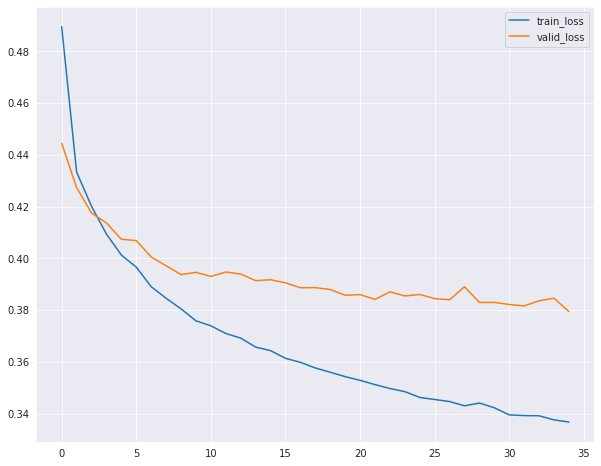

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
n_epochs = len(net.history)
sns.lineplot(range(n_epochs), net.history[:, 'train_loss'])
sns.lineplot(range(n_epochs), net.history[:, 'valid_loss'])
ax.legend(['train_loss', 'valid_loss'])

In [10]:
prob = net.predict_proba(x_test)
prob

array([0.75646, 0.50674, 0.63981, ..., 0.37142, 0.63996, 0.65172],
      dtype=float32)

In [13]:
y_pred = net.predict(x_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.9, 40)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [ ]:
threshold = 0.2
y_pred = (prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')